In [1]:
import json
import seaborn 
from math import ceil 
import pandas as pd
from pathlib import Path 
import plot_utils
import matplotlib as mpl
import matplotlib.pyplot as plt

import plot_utils
from importlib import reload
reload(plot_utils)

plot_utils.set_style()

## Functions 

In [2]:
def read_ini(filename): 
    with open(filename, 'r') as f: 
        lines = f.read().splitlines() 
    
    params = {}
    for line in lines: 
        p, val = line.split(': ')
        try: 
            val = float(val)
        except: 
            pass 
        params[p] = val
    return params

def read_summary(filename): 
    with open(filename, 'r') as f: 
        summary = json.load(f)
    return summary 

def get_info(folder: Path):
    sfile = folder / 'solution' / 'summary.json'
    pfile = folder / 'params.ini'
    if not sfile.exists() or not pfile.exists(): 
        print(f'Either summary or param file does not exist in {folder}, returning None')
        return None 
    
    summary = read_summary(sfile)
    params = read_ini(pfile)

    return {**summary, **params}


## Create df with all information 

In [3]:
folder = '../results/button_grid_nonlinear'

data = []
for subf in Path(folder).glob('*'):
    dat = get_info(subf)
    if dat is not None: 
        data.append(dat)

df = pd.DataFrame(data) # .sort_values(by='starting_material_budget', ascending=True)
convert_dict = {'starting_material_budget': int,
                'max_rxns': int
                }
 
df = df.astype(convert_dict)

Either summary or param file does not exist in ../results/button_grid_nonlinear/rxn_90_budget_10.0, returning None


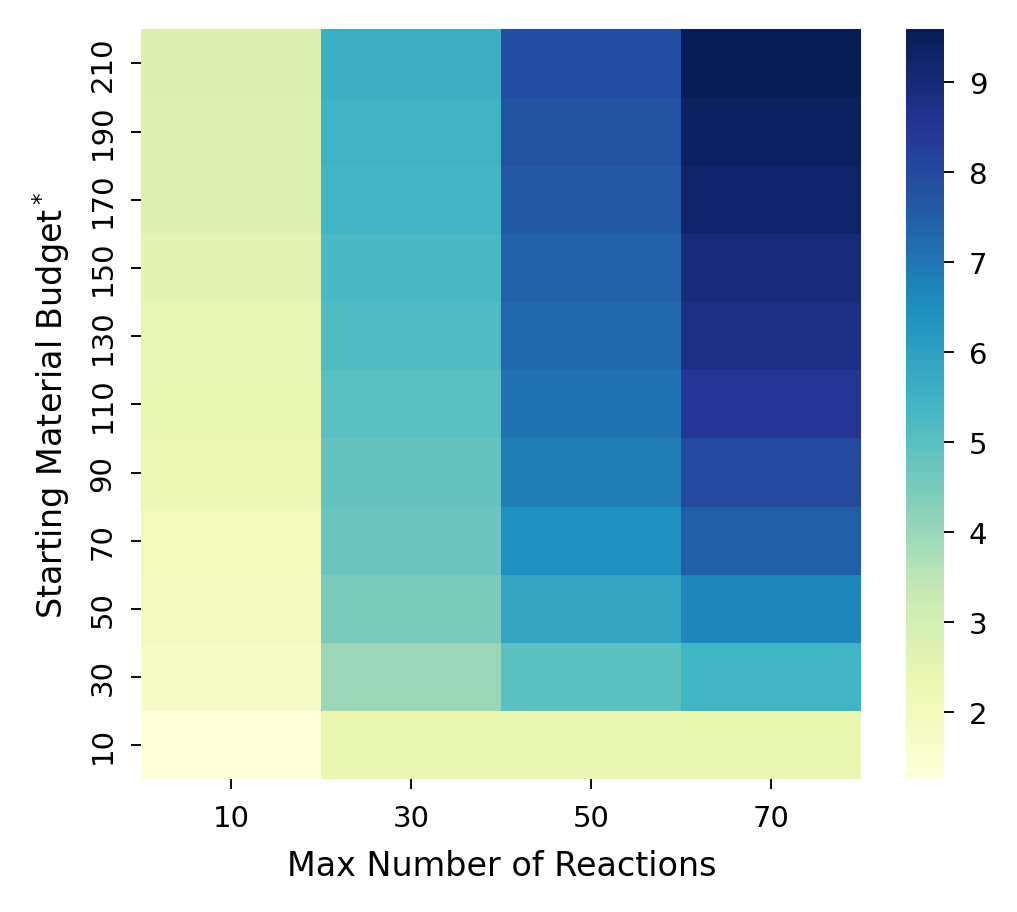

In [4]:
fig, ax = plt.subplots(1,1)
df_heatmap = df.sort_values(by='starting_material_budget').pivot(index='starting_material_budget', columns='max_rxns', values='Expected Reward').sort_index(ascending=False)
cmap = plt.get_cmap('YlGnBu')
seaborn.heatmap(df_heatmap, ax=ax, cmap=cmap)
ax.set_ylabel('Starting Material Budget$^*$')
ax.set_xlabel('Max Number of Reactions')
plot_utils.set_size(w=3, h=2.5, ax=ax)

